<a href="https://colab.research.google.com/github/TomographicImaging/gVXR-Tutorials/blob/main/notebooks/Gate_gVXR-comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
#
#  Copyright 2025 United Kingdom Research and Innovation
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    Franck Vidal (UKRI-STFC)

![gVXR](https://github.com/TomographicImaging/gVXR-Tutorials/blob/main/img/Logo-transparent-small.png?raw=1) ![OpenGate](https://gate.uca.fr/uas/GATE/LOGO_CLAIR/GATE_logo.png)


# Photonic noise: Comparison between gVXR and Gate

In this notebook, we run a simulation with gVXR and the corresponding one with Gate. Both simulations use the same number of emitted photons. This is to make sure the noise is well callibrated in gVXR.

![Image comparison](https://github.com/TomographicImaging/gVXR-Tutorials/blob/main/notebooks/output_data/Gate_gVXR-comparison/without_scintillation/compare-5000000photons.png?raw=1)

<!-- <div class="alert alert-block alert-warning">
    <b>Note:</b> Make sure the Python packages are already installed. See <a href="../README.md">README.md</a> in the root directory of the repository. If you are running this notebook from Google Colab, please run the cell below to install the required packages.
</div> -->

## Aim and objectives of this session

<!-- The aim of this session is to replicate an actual scan.

To achieve this, the main objectives are to:-->

<!-- 1. Select the scintillation material and thickness.
2. Retrieve the energy response and plot it.
3. Visualise the effect of scintillation on a phantom. -->

<!-- ![Screenshot of the 3D environment using K3D](https://github.com/TomographicImaging/gVXR-Tutorials/blob/main/notebooks/output_data/multi_material-CT_scan/k3d_screenshot-cropped.png?raw=1) -->

In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install gvxr opengate

## Import packages

In [3]:
import os
from pathlib import Path
from time import time
from math import log10

# import urllib, zipfile # Download and extract the phantom data
import numpy as np
import pandas as pd
import opengate as gate
# from scipy.spatial.transform import Rotation
import multiprocessing

# # import SimpleITK as sitk
from tifffile import imwrite
# import xraylib as xrl

import matplotlib
import matplotlib.pyplot as plt
# from matplotlib.gridspec import GridSpec

# import matplotlib
# # matplotlib.use('TkAGG')   # generate postscript output by default
# # matplotlib.use("Qt5Agg")

# plt.rcParams['figure.figsize'] = [13, 7]
# plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

font = {'family' : 'serif',
        'size'   : 15
    }
matplotlib.rc('font', **font)

# Uncomment the line below to use LaTeX fonts
# matplotlib.rc('text', usetex=True)


from gvxrPython3 import gvxr
from gvxrPython3.utils import loadSpekpySpectrum


K3D is not install, you won't be able to visualise the 3D scene using k3D
xpecgen is not install, you won't be able to load a beam spectrum using xpecgen


## Define new functions

Initialise the simulation with gVXR

In [4]:
def initGVXR():
    gvxr.createOpenGLContext()
    gvxr.setSourcePosition(*source_focus_point_position_in_mm, "mm");
    gvxr.usePointSource();

    # gvxr.setMonoChromatic(energy_in_keV, "keV", number_of_photons_per_pixel);

    spectrum = loadSpekpySpectrum(kvp, 
        filters=filtration,
        th_in_deg=12,
        max_number_of_energy_bins=50,
    )

    gvxr.setNumberOfPhotonsPerPixelAtSDD(number_of_photons_per_pixel)
            
    gvxr.enablePoissonNoise()

    gvxr.setDetectorPosition(*detector_position_in_mm, "mm");
    gvxr.setDetectorUpVector(0, 1, 0);
    gvxr.setDetectorRightVector(1, 0, 0);
    gvxr.setDetectorNumberOfPixels(detector_cols, detector_rows);
    gvxr.setDetectorPixelSize(pixel_size_in_mm[0], pixel_size_in_mm[1], "mm");

    if use_scintillation:
        gvxr.setScintillator("Gd2O2S DRZ-Plus", scintillator_thickness_in_mm, "mm")

    gvxr.makeCuboid("Ti90Al6V4Box", *Ti90Al6V4Box_size_in_cm, "cm")
    gvxr.translateNode("Ti90Al6V4Box", *Ti90Al6V4Box_translation_in_cm, "cm")
    gvxr.addPolygonMeshAsInnerSurface("Ti90Al6V4Box")
    gvxr.setMixture("Ti90Al6V4Box", "Ti90Al6V4")
    gvxr.setDensity("Ti90Al6V4Box", 4.43, "g/cm3")
    gvxr.setColour("Ti90Al6V4Box", 135.0 / 255.0, 134.0 / 255.0, 129.0 / 255.0, 1.0)
    gvxr.setShininess("Ti90Al6V4Box", 150.0)

    gvxr.makeCuboid("BrassBox", *BrassBox_size_in_cm, "cm")
    gvxr.translateNode("BrassBox", *BrassBox_translation_in_cm, "cm")
    gvxr.addPolygonMeshAsInnerSurface("BrassBox")
    gvxr.setMixture("BrassBox", ["Cu", "Zn"], [0.666666, 0.333334])
    gvxr.setDensity("BrassBox", 8.565, "g/cm3")
    gvxr.setColour("BrassBox", 177.0 / 255.0, 163.0 / 255.0, 66.0 / 255.0, 1.0)
    gvxr.setShininess("BrassBox", 100.0)

    gvxr.makeCuboid("SiCBox", *SiCBox_size_in_cm, "cm")
    gvxr.translateNode("SiCBox", *SiCBox_translation_in_cm, "cm")
    gvxr.addPolygonMeshAsInnerSurface("SiCBox")
    gvxr.setCompound("SiCBox", "SiC")
    gvxr.setDensity("SiCBox", 3.16, "g/cm3")
    gvxr.setColour("SiCBox", 1.0, 1.0, 1.0, 1.0)
    gvxr.setShininess("SiCBox", 100.0)

    gvxr.makeCuboid("CarbonSteelBox", *CarbonSteelBox_size_in_cm, "cm")
    gvxr.translateNode("CarbonSteelBox", *CarbonSteelBox_translation_in_cm, "cm")
    gvxr.addPolygonMeshAsInnerSurface("CarbonSteelBox")
    gvxr.setMixture("CarbonSteelBox", 
        ["Mn", "C", "S", "P", "Fe"], 
        [0.0075, 0.00175, 0.00025, 0.0002, 0.9903])
    gvxr.setDensity("CarbonSteelBox", 7.87, "g/cm3")
    gvxr.setColour("CarbonSteelBox", 88.0 / 255.0, 94.0 / 255.0, 94.0 / 255.0, 1.0)
    gvxr.setShininess("CarbonSteelBox", 100.0)


    gvxr.makeCuboid("aluminiumbox", *aluminiumbox_size_in_cm, "cm")
    gvxr.translateNode("aluminiumbox", *aluminiumbox_translation_in_cm, "cm")
    gvxr.addPolygonMeshAsInnerSurface("aluminiumbox")
    gvxr.setElement("aluminiumbox", "Al")
    gvxr.setColour("aluminiumbox", 217.0 / 255.0, 218.0 / 255.0, 217.0 / 255.0, 1.0)
    gvxr.setShininess("aluminiumbox", 150.0)

    return spectrum


Run the simulation with gVXR

In [5]:
def runGVXR():
    gvxr_attenuation_image = np.array(gvxr.computeXRayImage())

    gvxr_flat_image = np.zeros(gvxr_attenuation_image.shape, dtype=np.single)
    
    for i in range(white_images):
        gvxr_flat_image += np.array(gvxr.getWhiteImage())

    gvxr_flat_image /= white_images
    return gvxr_attenuation_image, gvxr_flat_image 

Initialise the simulation with Gate

In [6]:
def initGate(spectrum):
    sim = gate.Simulation()

    sim.g4_verbose = False
    sim.g4_verbose_level = 1
    sim.visu = False
    sim.visu_type = "vrml"
    sim.random_engine = "MersenneTwister"
    sim.random_seed = "auto"
    if os.name != "nt":
        sim.number_of_threads = multiprocessing.cpu_count()
    else:
        sim.number_of_threads = 1
    print(f"Use {sim.number_of_threads} threads")
    sim.progress_bar = True
    sim.output_dir = output_dir

    sim.volume_manager.add_material_database(data_path / "GateMaterials.db")

    sim.physics_manager.physics_list_name = "G4EmStandardPhysics_option4"

    # world
    world = sim.world
    world.size = [3 * m, 3 * m, 3 * m]
    # world.material = "G4_AIR"
    world.material = "Vacuum"

    # CBCT gantry source
    gantry = sim.add_volume("Box", "CBCT_gantry")
    gantry.size = [0.2 * m, 0.2 * m, 0.2 * m]
    # gantry.material = "G4_AIR"
    gantry.material = "Vacuum"
    gantry.color = [0, 1, 1, 1]
    gantry.translation = gantry_position_in_mm * mm

    # CBCT detector plane
    detector_plane = sim.add_volume("Box", "CBCT_detector_plane")
    detector_plane.size = [409.6 * mm, 409.6 * mm, scintillator_thickness_in_mm * mm]

    # detector_plane.size = [409.6 * mm, 409.6 * mm, 0.6 * mm]
    if use_scintillation:
        detector_plane.material = "Gd2O2S-DRZ-Plus"
    else:
        detector_plane.material = "G4_AIR"
    # detector_plane.material = "CsI"
    detector_plane.color = [1, 0, 0, 1]
    detector_plane.translation = detector_position_in_mm * mm

    # actor
    if use_scintillation:
        detector_actor = sim.add_actor("DoseActor", "detector_actor")
    else:
        detector_actor = sim.add_actor("FluenceActor", "detector_actor")
    detector_actor.attached_to = detector_plane
    # detector_actor.output_filename = fname
    detector_actor.spacing = pixel_size_in_mm * mm
    detector_actor.size = [detector_cols, detector_rows, 1]
    detector_actor.write_to_disk = False

    # physics
    sim.physics_manager.physics_list_name = "G4EmStandardPhysics_option1"
    sim.physics_manager.set_production_cut("world", "all", 10 * mm)

    # source
    source = sim.add_source("GenericSource", "mysource")
    source.attached_to = gantry.name
    source.particle = "gamma"

    # source.energy.mono = energy_in_keV * keV

    source.energy.type = "spectrum_discrete"
    source.energy.spectrum_energies = np.array(spectrum[1], dtype=np.single) * float(keV)
    source.energy.spectrum_weights = np.array(spectrum[2], dtype=np.single) / np.sum(spectrum[2])

    source.position.type = "box"
    source.position.size = source_size_in_mm * mm
    source.direction.type = "focused"
    source.direction.focus_point = source_focus_point_position_in_mm * mm
    source.n = total_number_of_photons / sim.number_of_threads

    return sim, detector_actor


def addPhantom(sim, use_dummy):
    Ti90Al6V4Box = sim.add_volume("Box", "Ti90Al6V4Box")
    Ti90Al6V4Box.size = Ti90Al6V4Box_size_in_cm * cm
    Ti90Al6V4Box.translation = Ti90Al6V4Box_translation_in_cm * cm
    Ti90Al6V4Box.color = [0, 0, 1, 1]  # this is RGBa (a=alpha=opacity), so blue here

    BrassBox = sim.add_volume("Box", "BrassBox")
    BrassBox.size = BrassBox_size_in_cm * cm
    BrassBox.translation = BrassBox_translation_in_cm * cm
    BrassBox.color = [0, 0, 1, 1]  # this is RGBa (a=alpha=opacity), so blue here

    SiCBox = sim.add_volume("Box", "SiCBox")
    SiCBox.size = SiCBox_size_in_cm * cm
    SiCBox.translation = SiCBox_translation_in_cm * cm
    SiCBox.color = [0, 0, 1, 1]  # this is RGBa (a=alpha=opacity), so blue here

    CarbonSteelBox = sim.add_volume("Box", "CarbonSteelBox")
    CarbonSteelBox.size = CarbonSteelBox_size_in_cm * cm
    CarbonSteelBox.translation = CarbonSteelBox_translation_in_cm * cm
    CarbonSteelBox.color = [0, 0, 1, 1]  # this is RGBa (a=alpha=opacity), so blue here

    aluminiumbox = sim.add_volume("Box", "aluminiumbox")
    aluminiumbox.size = aluminiumbox_size_in_cm * cm
    aluminiumbox.translation = aluminiumbox_translation_in_cm * cm
    aluminiumbox.color = [0, 0, 1, 1]  # this is RGBa (a=alpha=opacity), so blue here

    if not use_dummy:
        Ti90Al6V4Box.material = "Ti6Al4V"
        BrassBox.material = "Brass"
        SiCBox.material = "SiC"
        CarbonSteelBox.material = "CarbonSteel"
        aluminiumbox.material = "Aluminium"
    else:
        Ti90Al6V4Box.material = "Vacuum"
        BrassBox.material = "Vacuum"
        SiCBox.material = "Vacuum"
        CarbonSteelBox.material = "Vacuum"
        aluminiumbox.material = "Vacuum"


Define global variables

In [7]:
data_path = Path("../data")

kvp = 160
filtration = [["Cu", 0.4, "mm"]]

# units
m = gate.g4_units.m
cm = gate.g4_units.cm
nm = gate.g4_units.nm
cm3 = gate.g4_units.cm3
keV = gate.g4_units.keV
MeV = gate.g4_units.MeV
mm = gate.g4_units.mm
Bq = gate.g4_units.Bq
gcm3 = gate.g4_units.g / cm3

SOD_in_mm = 1000
ODD_in_mm = 536
SDD_in_mm = SOD_in_mm + ODD_in_mm
        

source_focus_point_position_in_mm   = np.array([0, 0, SOD_in_mm])
gantry_position_in_mm   = np.array([0, 0, SOD_in_mm + 60])
detector_position_in_mm = np.array([0, 0, -ODD_in_mm])

Ti90Al6V4Box_size_in_cm = np.array([7.0, 7.0, 0.5])
Ti90Al6V4Box_translation_in_cm = np.array([4.0, 4.0, 0.0])

BrassBox_size_in_cm = np.array([7.0, 7.0, 0.2])
BrassBox_translation_in_cm = np.array([-4.0, 4.0, 0.0])

SiCBox_size_in_cm = np.array([7.0, 7.0, 1.0])
SiCBox_translation_in_cm = np.array([4.0, -4.0, 0.0])

CarbonSteelBox_size_in_cm = np.array([7.0, 7.0, 0.2])
CarbonSteelBox_translation_in_cm = np.array([-4.0, -4.0, 0.0])

aluminiumbox_size_in_cm = np.array([20.0, 20.0, 1.5])
aluminiumbox_translation_in_cm = np.array([0.0, 0.0, -5.0])

source_size_in_mm = np.array([16, 16, 1e-6])

detector_cols = 100
detector_rows = 100

detector_size_in_mm = np.array([
    (abs(detector_position_in_mm[2]) + abs(source_focus_point_position_in_mm[2])) * source_size_in_mm[0] / abs(gantry_position_in_mm[2] - source_focus_point_position_in_mm[2]),
    (abs(detector_position_in_mm[2]) + abs(source_focus_point_position_in_mm[2])) * source_size_in_mm[1] / abs(gantry_position_in_mm[2] - source_focus_point_position_in_mm[2])
])

pixel_size_in_mm = np.array([detector_size_in_mm[0] / detector_cols, detector_size_in_mm[1] / detector_rows, 10])

use_scintillation = False

if use_scintillation:
    scintillator_thickness_in_mm = 0.21
else:
    scintillator_thickness_in_mm = 1e-6

# energy_in_keV = 60
total_number_of_photons = 5000000
number_of_photons_per_pixel = max(1,round(total_number_of_photons / (detector_cols * detector_rows)))

white_images = 10

Where to save the data

In [8]:
if use_scintillation:
    output_dir = "./output_data/Gate_gVXR-comparison/with_scintillation"
else:
    output_dir = "./output_data/Gate_gVXR-comparison/without_scintillation"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

gate_flat_image_fname = "gate_flat_image-" + str(total_number_of_photons) + "photons.tif"
gate_attenuation_image_fname = "gate_attenuation_image-" + str(total_number_of_photons) + "photons.tif"
gvxr_flat_image_fname = "gvxr_flat_image-" + str(total_number_of_photons) + "photons.tif"
gvxr_attenuation_image_fname = "gvxr_attenuation_image-" + str(total_number_of_photons) + "photons.tif"

Initialise gVXR and run the simulation

In [9]:
spectrum = initGVXR()
gvxr_start_time = time()
gvxr_attenuation_image, gvxr_flat_image = runGVXR()
gvxr_stop_time = time()
execution_time_gvxr = gvxr_stop_time - gvxr_start_time
gvxr.setMarkerLength(0.0, "mm")

gvxr_flat_image[gvxr_flat_image<1e-6] = 1e-6

Wed May 28 21:20:10 2025 ---- Create window (ID: -1)
Wed May 28 21:20:10 2025 ---- Request an interactive OpenGL context
Wed May 28 21:20:10 2025 ---- Initialise GLFW
Wed May 28 21:20:10 2025 ---- Create an OpenGL window with a 4.3 context.
Wed May 28 21:20:10 2025 ---- Make the window's context current
Wed May 28 21:20:10 2025 ---- Initialise GLEW
Wed May 28 21:20:10 2025 ---- OpenGL vendor: NVIDIA Corporation
Wed May 28 21:20:10 2025 ---- OpenGL renderer: NVIDIA GeForce RTX 4060 Ti/PCIe/SSE2
Wed May 28 21:20:10 2025 ---- OpenGL version: 4.3.0 NVIDIA 560.28.03
Wed May 28 21:20:10 2025 ---- Use OpenGL 4.5.
Wed May 28 21:20:10 2025 ---- Use OpenGL Compute Shader.
Wed May 28 21:20:10 2025 ---- Initialise the X-ray renderer if needed and if possible
Wed May 28 21:20:10 2025 (WW) addEnergyBinToSpectrum is deprecated. It will be removed in a future release. Choose addEnergyBinToSpectrumPerPixelAtSDD or addEnergyBinToSpectrumPerCm2At1m. Note that addEnergyBinToSpectrum and addEnergyBinToSpec

Save the images

In [10]:
# sitk_image = sitk.GetImageFromArray(gvxr_flat_image.astype(np.single))
# sitk.WriteImage(sitk_image, os.path.join(output_dir, gvxr_flat_image_fname))

# sitk_image = sitk.GetImageFromArray(gvxr_attenuation_image.astype(np.single))
# sitk.WriteImage(sitk_image, os.path.join(output_dir, gvxr_attenuation_image_fname))

imwrite(os.path.join(output_dir, gvxr_flat_image_fname), gvxr_flat_image.astype(np.single))
imwrite(os.path.join(output_dir, gvxr_attenuation_image_fname), gvxr_attenuation_image.astype(np.single))


Initialise Gate with the sample and run the simulation

In [11]:
sim, detector_actor = initGate(spectrum)
addPhantom(sim, use_dummy=False)
gate_start_time = time()
sim.run(True)
gate_stop_time = time()
execution_time_gate = gate_stop_time - gate_start_time

if use_scintillation:
    gate_attenuation_image = np.asarray(detector_actor.edep.image)[0]
else:
    gate_attenuation_image = np.asarray(detector_actor.fluence.image)[0]

Use 24 threads
Dispatching simulation to subprocess ...
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ :02s<00m:00s] 

Initialise Gate without the sample and run the simulation several times to create the flat image with noise (as i a real experiment).

In [12]:
gate_flat_image = np.zeros(gate_attenuation_image.shape, dtype=np.single)
for i in range(white_images):
    sim, detector_actor = initGate(spectrum)
    addPhantom(sim, use_dummy=True)
    gate_start_time = time()
    sim.run(True)
    gate_stop_time = time()
    execution_time_gate += gate_stop_time - gate_start_time

    if use_scintillation:
        gate_flat_image += np.asarray(detector_actor.edep.image)[0]
    else:
        gate_flat_image += np.asarray(detector_actor.fluence.image)[0]

gate_flat_image /= white_images


Use 24 threads
Dispatching simulation to subprocess ...
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ :02s<00m:00s] ■■■■■■■■■■                               :01s<00m:01s]                   :01s<00m:01s] Use 24 threads
Dispatching simulation to subprocess ...
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ :02s<00m:00s] Use 24 threads
Dispatching simulation to subprocess ...
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ :02s<00m:00s] Use 24 threads
Dispatching simulation to subprocess ...
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ :02s<00m:00s] Use 24 threads
Dispatching simulation to subprocess ...
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ :02s<00m:00s] Use 24 threads
Dispatching simulation to subprocess ...
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ :02s<00m:00s] Use 24 threads
Dispatching simulation to subprocess ...
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ :02s<00m:00s]                  :00s<00m:02s] Use 24 threads
Dispatching simulati

Save the images

In [13]:
imwrite(os.path.join(output_dir, gate_attenuation_image_fname), gate_attenuation_image.astype(np.single))
imwrite(os.path.join(output_dir, gate_flat_image_fname), gate_flat_image.astype(np.single))

Compute the speed-up

In [14]:
speedup = execution_time_gate / execution_time_gvxr

print("********************************************************************************")
print("Total number of particles:", total_number_of_photons)
print("Execution time with Gate [in sec]:", "{:.2f}".format(execution_time_gate))
print("Execution time with gVXR [in sec]:", "{:.2f}".format(execution_time_gvxr))
print("Speedup:", round(speedup))
print("********************************************************************************")

********************************************************************************
Total number of particles: 5000000
Execution time with Gate [in sec]: 114.98
Execution time with gVXR [in sec]: 0.06
Speedup: 1815
********************************************************************************


Compare the images

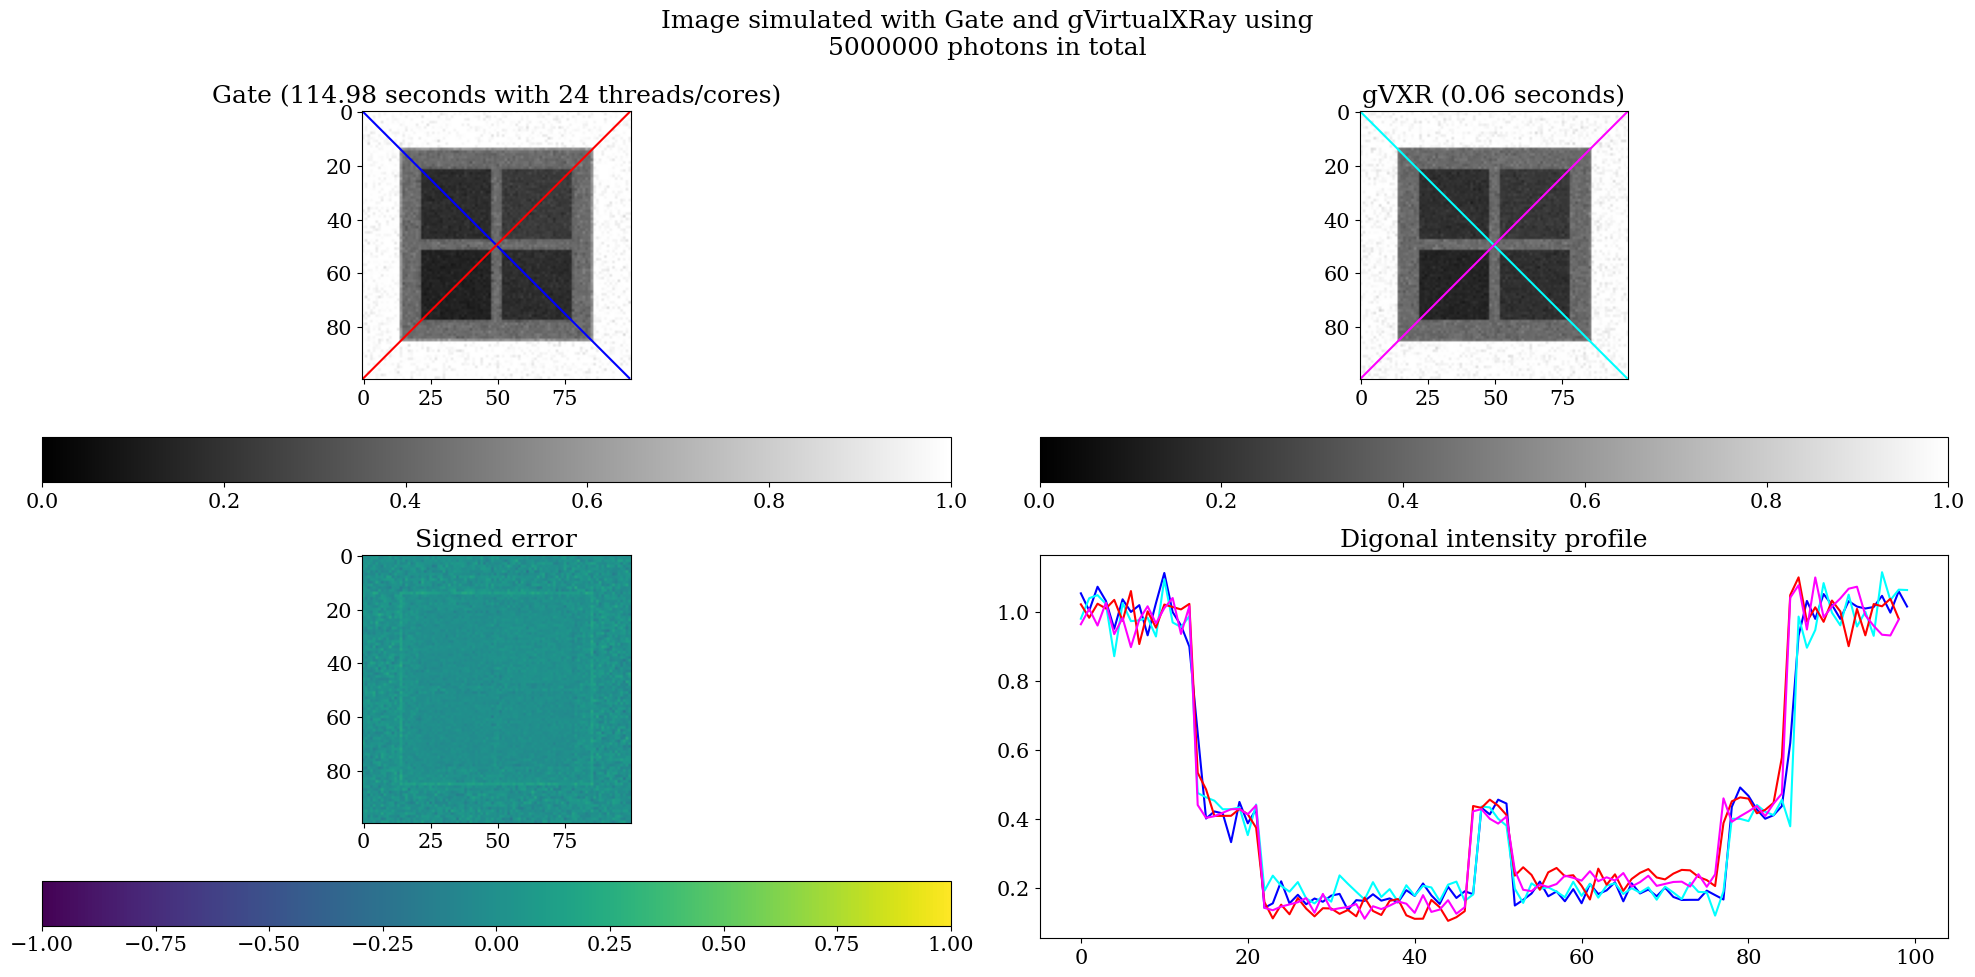

In [15]:
plot_fname = "compare-" + str(total_number_of_photons) + "photons"
plt.figure(figsize= (20,10))

plt.suptitle("Image simulated with Gate and gVirtualXRay using\n" + str(total_number_of_photons) + " photons in total")#, y=1.02)

plt.subplot(221)

selection = gate_attenuation_image[0:17]

gate_normalised_image = gate_attenuation_image / gate_flat_image
gate_normalised_image[gate_attenuation_image < 1e-4] = 1e-4
# gate_normalised_image = gate_attenuation_image / np.mean(gate_attenuation_image[0:17])

plt.imshow(gate_normalised_image, cmap="gray", vmin=0, vmax=1)
plt.plot([0, gate_normalised_image.shape[1]-1], [0, gate_normalised_image.shape[0]-1], color="blue")#, linestyle='dashed')
plt.plot([gate_normalised_image.shape[1]-1, 0], [0, gate_normalised_image.shape[0]-1], color="red")#, linestyle='dashed')
plt.colorbar(orientation='horizontal')
# plt.title("Gate (" + str(timedelta(seconds=gate_stop_time - gate_start_time)) + ")")
plt.title("Gate (" + "{:.2f}".format(execution_time_gate) + " seconds with " + str(sim.number_of_threads) + " threads/cores)")

plt.subplot(222)
gvxr_normalised_image = gvxr_attenuation_image / gvxr_flat_image
# gvxr_normalised_image = gvxr_attenuation_image / np.mean(gvxr_attenuation_image[0:17])

plt.imshow(gvxr_normalised_image, cmap="gray", vmin=0, vmax=1)
plt.plot([0, gvxr_normalised_image.shape[1]-1], [0, gvxr_normalised_image.shape[0]-1], color="cyan")#, linestyle='dotted')
plt.plot([gvxr_normalised_image.shape[1]-1, 0], [0, gvxr_normalised_image.shape[0]-1], color="magenta")#, linestyle='dashed')
plt.colorbar(orientation='horizontal')
# plt.title("gVXR (" + str(timedelta(seconds=gvxr_stop_time - gvxr_start_time)) + ")")
plt.title("gVXR (" + "{:.2f}".format(execution_time_gvxr) + " seconds)")

plt.subplot(223)
relative_error = gate_normalised_image - gvxr_normalised_image
plt.imshow(relative_error, vmin=-1, vmax=1)
plt.colorbar(orientation='horizontal')
plt.title("Signed error")

plt.subplot(224)
plt.plot(np.diag(gate_normalised_image), label="Gate", color="blue")#, linestyle='dashed')
plt.plot(np.diag(gvxr_normalised_image), label="gVXR", color="cyan")#, linestyle='dotted')
plt.plot(np.diag(np.flipud(gate_normalised_image), 1), label="Gate", color="red")
plt.plot(np.diag(np.flipud(gvxr_normalised_image), 1), label="gVXR", color="magenta")

plt.title("Digonal intensity profile")
# plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_dir, plot_fname + ".pdf"))
plt.savefig(os.path.join(output_dir, plot_fname + ".png"))
# plt.close()
# plt.show()

Compare the noise in the different regions of the image

In [16]:
Ti90Al6V4box_centre      = [65,65]
brassbox_centre     = [34,65]
SiCbox_centre     = [65,34]
carbon_steelbox_centre = [34,34]
roi_width = 24
roi_half_width = roi_width // 2

# Ti90Al6V4box
gate_Ti90Al6V4box_roi = np.ma.masked_invalid(gate_normalised_image[ \
    Ti90Al6V4box_centre[1]-roi_half_width:Ti90Al6V4box_centre[1]+roi_half_width+1,
    Ti90Al6V4box_centre[0]-roi_half_width:Ti90Al6V4box_centre[0]+roi_half_width+1
])

gvxr_Ti90Al6V4box_roi = np.ma.masked_invalid(gvxr_normalised_image[ \
    Ti90Al6V4box_centre[1]-roi_half_width:Ti90Al6V4box_centre[1]+roi_half_width+1,
    Ti90Al6V4box_centre[0]-roi_half_width:Ti90Al6V4box_centre[0]+roi_half_width+1
])

# brassbox
gate_brassbox_roi = np.ma.masked_invalid(gate_normalised_image[
    brassbox_centre[1]-roi_half_width:brassbox_centre[1]+roi_half_width+1,
    brassbox_centre[0]-roi_half_width:brassbox_centre[0]+roi_half_width+1
])

gvxr_brassbox_roi = np.ma.masked_invalid(gvxr_normalised_image[
    brassbox_centre[1]-roi_half_width:brassbox_centre[1]+roi_half_width+1,
    brassbox_centre[0]-roi_half_width:brassbox_centre[0]+roi_half_width+1
])

# SiCbox
gate_SiCbox_roi = np.ma.masked_invalid(gate_normalised_image[
    SiCbox_centre[1]-roi_half_width:SiCbox_centre[1]+roi_half_width+1,
    SiCbox_centre[0]-roi_half_width:SiCbox_centre[0]+roi_half_width+1
])

gvxr_SiCbox_roi = np.ma.masked_invalid(gvxr_normalised_image[
    SiCbox_centre[1]-roi_half_width:SiCbox_centre[1]+roi_half_width+1,
    SiCbox_centre[0]-roi_half_width:SiCbox_centre[0]+roi_half_width+1
])

# carbon_steelbox
gate_carbon_steelbox_roi = np.ma.masked_invalid(gate_normalised_image[
    carbon_steelbox_centre[1]-roi_half_width:carbon_steelbox_centre[1]+roi_half_width+1,
    carbon_steelbox_centre[0]-roi_half_width:carbon_steelbox_centre[0]+roi_half_width+1
])

gvxr_carbon_steelbox_roi = np.ma.masked_invalid(gvxr_normalised_image[
    carbon_steelbox_centre[1]-roi_half_width:carbon_steelbox_centre[1]+roi_half_width+1,
    carbon_steelbox_centre[0]-roi_half_width:carbon_steelbox_centre[0]+roi_half_width+1
])

# carbon_steelbox
gate_carbon_steelbox_roi = np.ma.masked_invalid(gate_normalised_image[
    carbon_steelbox_centre[1]-roi_half_width:carbon_steelbox_centre[1]+roi_half_width+1,
    carbon_steelbox_centre[0]-roi_half_width:carbon_steelbox_centre[0]+roi_half_width+1
])

gvxr_carbon_steelbox_roi = np.ma.masked_invalid(gvxr_normalised_image[
    carbon_steelbox_centre[1]-roi_half_width:carbon_steelbox_centre[1]+roi_half_width+1,
    carbon_steelbox_centre[0]-roi_half_width:carbon_steelbox_centre[0]+roi_half_width+1
])

# Void
gate_void_roi = np.ma.masked_invalid(gate_normalised_image[
    0:17,
    0:100
])

gvxr_void_roi = np.ma.masked_invalid(gvxr_normalised_image[
    0:17,
    0:100
])

# Void
gate_Al_roi = np.ma.masked_invalid(gate_normalised_image[
    16:20,
    16:80
])

gvxr_Al_roi = np.ma.masked_invalid(gvxr_normalised_image[
    16:20,
    16:80
])

data = []
labels = []

data.append(gate_void_roi.flatten())
data.append(gvxr_void_roi.flatten())

labels.append("Air\nGate")
labels.append("Air\ngVXR")

data.append(gate_Al_roi.flatten())
data.append(gvxr_Al_roi.flatten())

labels.append("Al\nGate")
labels.append("Al\ngVXR")

data.append(gate_Ti90Al6V4box_roi.flatten())
data.append(gvxr_Ti90Al6V4box_roi.flatten())

labels.append("TiAlV\nGate")
labels.append("TiAlV\ngVXR")

data.append(gate_brassbox_roi.flatten())
data.append(gvxr_brassbox_roi.flatten())

labels.append("Brass\nGate")
labels.append("Brass\ngVXR")

data.append(gate_SiCbox_roi.flatten())
data.append(gvxr_SiCbox_roi.flatten())

labels.append("SiC\nGate")
labels.append("SiC\ngVXR")

data.append(gate_carbon_steelbox_roi.flatten())
data.append(gvxr_carbon_steelbox_roi.flatten())

labels.append("Steel\nGate")
labels.append("Steel\ngVXR")


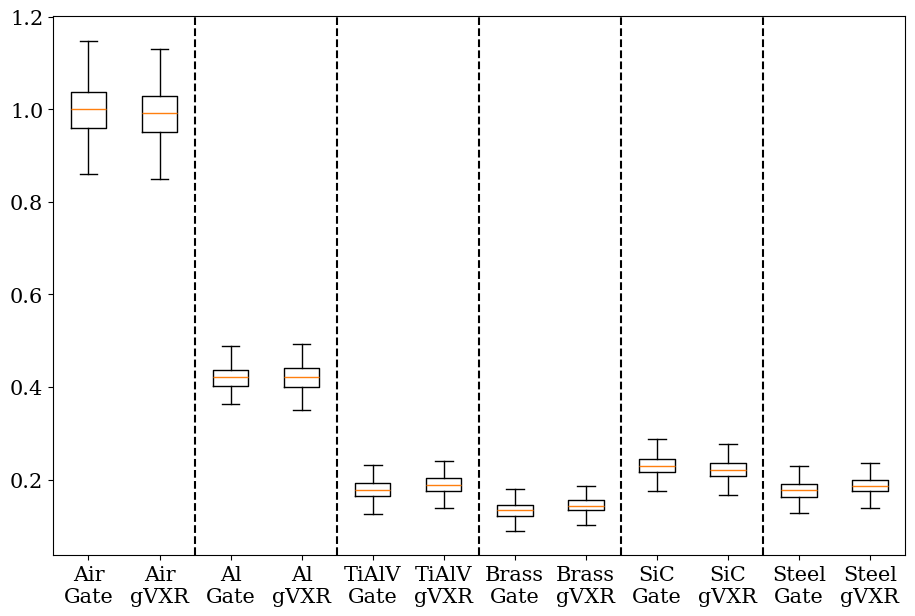

In [17]:
plt.figure(figsize=(11,7))
# plt.title("Pixel values in the different regions for\n" + str(total_number_of_photons) + " photons")
plt.boxplot(data, tick_labels=labels, showfliers=False)

for i in range(5):
    plt.axvline(i*2+2.5, color='k', linestyle='--')

plt.savefig(os.path.join(output_dir, "pixel_distribution-" + str(total_number_of_photons) + "photons.pdf"))
plt.savefig(os.path.join(output_dir, "pixel_distribution-" + str(total_number_of_photons) + "photons.png"))


Create a DataFrame to store the statistics

In [18]:
columns = ["total_number_of_photons", 
    "With/Without scintillator",

    "Gate Air mean", "Gate Air stddev",
    "gVXR Air mean", "gVXR Air stddev",
    "SNR Gate Air", "SNR gVXR Air", 
    "Relative error Air mean", "Relative error Air stddev", "Relative error Air SNR",

    "Gate Aluminium mean", "Gate Aluminium stddev",
    "gVXR Aluminium mean", "gVXR Aluminium stddev",
    "SNR Gate Aluminium", "SNR gVXR Aluminium", 
    "Relative error Aluminium mean", "Relative error Aluminium stddev", "Relative error Aluminium SNR",

    "Gate Ti90Al6V4 mean", "Gate Ti90Al6V4 stddev",
    "gVXR Ti90Al6V4 mean", "gVXR Ti90Al6V4 stddev",
    "SNR Gate Ti90Al6V4", "SNR gVXR Ti90Al6V4",
    "Relative error Ti90Al6V4 mean", "Relative error Ti90Al6V4 stddev", "Relative error Ti90Al6V4 SNR",

    "Gate Brass mean", "Gate Brass stddev",
    "gVXR Brass mean", "gVXR Brass stddev",
    "SNR Gate Brass", "SNR gVXR Brass", 
    "Relative error Brass mean", "Relative error Brass stddev", "Relative error Brass SNR",

    "Gate SiC mean", "Gate SiC stddev",
    "gVXR SiC mean", "gVXR SiC stddev",
    "SNR Gate SiC", "SNR gVXR SiC", 
    "Relative error SiC mean", "Relative error SiC stddev", "Relative error SiC SNR",

    "Gate Carbon steel mean", "Gate Carbon steel stddev",
    "gVXR Carbon steel mean", "gVXR Carbon steel stddev",
    "SNR Gate Carbon steel", "SNR gVXR Carbon steel",
    "Relative error Carbon steel mean", "Relative error Carbon steel stddev", "Relative error Carbon steel SNR",
]

statistical_data = []

row = [total_number_of_photons]

if use_scintillation:
    row.append("With")
else:
    row.append("Without")

# Void
gate_mean = np.mean(gate_void_roi)
gate_std = np.std(gate_void_roi)
gvxr_mean = np.mean(gvxr_void_roi)
gvxr_std = np.std(gvxr_void_roi)
gate_SNR = 10*log10(gate_mean/gate_std)
gvxr_SNR = 10*log10(gvxr_mean/gvxr_std)

row.append(gate_mean)
row.append(gate_std)
row.append(gvxr_mean)
row.append(gvxr_std)
row.append(gate_SNR)
row.append(gvxr_SNR)
row.append((gate_mean - gvxr_mean) / max(1e-6, gate_mean))
row.append((gate_std - gvxr_std) / max(1e-6, gate_std))
row.append((gate_SNR - gvxr_SNR) / max(1e-6, gate_SNR))

# Al
gate_mean = np.mean(gate_Al_roi)
gate_std = np.std(gate_Al_roi)
gvxr_mean = np.mean(gvxr_Al_roi)
gvxr_std = np.std(gvxr_Al_roi)
gate_SNR = 10*log10(gate_mean/gate_std)
gvxr_SNR = 10*log10(gvxr_mean/gvxr_std)

row.append(gate_mean)
row.append(gate_std)
row.append(gvxr_mean)
row.append(gvxr_std)
row.append(gate_SNR)
row.append(gvxr_SNR)
row.append((gate_mean - gvxr_mean) / max(1e-6, gate_mean))
row.append((gate_std - gvxr_std) / max(1e-6, gate_std))
row.append((gate_SNR - gvxr_SNR) / max(1e-6, gate_SNR))

# Ti90Al6V4
gate_mean = np.mean(gate_Ti90Al6V4box_roi)
gate_std = np.std(gate_Ti90Al6V4box_roi)
gvxr_mean = np.mean(gvxr_Ti90Al6V4box_roi)
gvxr_std = np.std(gvxr_Ti90Al6V4box_roi)
gate_SNR = 10*log10(gate_mean/gate_std)
gvxr_SNR = 10*log10(gvxr_mean/gvxr_std)

row.append(gate_mean)
row.append(gate_std)
row.append(gvxr_mean)
row.append(gvxr_std)
row.append(gate_SNR)
row.append(gvxr_SNR)
row.append((gate_mean - gvxr_mean) / max(1e-6, gate_mean))
row.append((gate_std - gvxr_std) / max(1e-6, gate_std))
row.append((gate_SNR - gvxr_SNR) / max(1e-6, gate_SNR))

# Brass
gate_mean = np.mean(gate_brassbox_roi)
gate_std = np.std(gate_brassbox_roi)
gvxr_mean = np.mean(gvxr_brassbox_roi)
gvxr_std = np.std(gvxr_brassbox_roi)
gate_SNR = 10*log10(gate_mean/gate_std)
gvxr_SNR = 10*log10(gvxr_mean/gvxr_std)

row.append(gate_mean)
row.append(gate_std)
row.append(gvxr_mean)
row.append(gvxr_std)
row.append(gate_SNR)
row.append(gvxr_SNR)
row.append((gate_mean - gvxr_mean) / max(1e-6, gate_mean))
row.append((gate_std - gvxr_std) / max(1e-6, gate_std))
row.append((gate_SNR - gvxr_SNR) / max(1e-6, gate_SNR))

# SiC
gate_mean = np.mean(gate_SiCbox_roi)
gate_std = np.std(gate_SiCbox_roi)
gvxr_mean = np.mean(gvxr_SiCbox_roi)
gvxr_std = np.std(gvxr_SiCbox_roi)
gate_SNR = 10*log10(gate_mean/gate_std)
gvxr_SNR = 10*log10(gvxr_mean/gvxr_std)

row.append(gate_mean)
row.append(gate_std)
row.append(gvxr_mean)
row.append(gvxr_std)
row.append(gate_SNR)
row.append(gvxr_SNR)
row.append((gate_mean - gvxr_mean) / max(1e-6, gate_mean))
row.append((gate_std - gvxr_std) / max(1e-6, gate_std))
row.append((gate_SNR - gvxr_SNR) / max(1e-6, gate_SNR))

# Carbon steel
gate_mean = np.mean(gate_carbon_steelbox_roi)
gate_std = np.std(gate_carbon_steelbox_roi)
gvxr_mean = np.mean(gvxr_carbon_steelbox_roi)
gvxr_std = np.std(gvxr_carbon_steelbox_roi)
gate_SNR = 10*log10(gate_mean/gate_std)
gvxr_SNR = 10*log10(gvxr_mean/gvxr_std)

row.append(gate_mean)
row.append(gate_std)
row.append(gvxr_mean)
row.append(gvxr_std)
row.append(gate_SNR)
row.append(gvxr_SNR)
row.append((gate_mean - gvxr_mean) / max(1e-6, gate_mean))
row.append((gate_std - gvxr_std) / max(1e-6, gate_std))
row.append((gate_SNR - gvxr_SNR) / max(1e-6, gate_SNR))

statistical_data.append(row)

df = pd.DataFrame(data=statistical_data, columns=columns)

Display the DataFrame

In [19]:
display(df)

,total_number_of_photons,With/Without scintillator,Gate Air mean,Gate Air stddev,gVXR Air mean,gVXR Air stddev,SNR Gate Air,SNR gVXR Air,Relative error Air mean,Relative error Air stddev,...,Relative error SiC SNR,Gate Carbon steel mean,Gate Carbon steel stddev,gVXR Carbon steel mean,gVXR Carbon steel stddev,SNR Gate Carbon steel,SNR gVXR Carbon steel,Relative error Carbon steel mean,Relative error Carbon steel stddev,Relative error Carbon steel SNR
0,5000000,Without,0.94137,0.186107,0.928268,0.196316,7.039986,6.747169,0.013918,-0.05486,...,0.031821,0.176206,0.019316,0.187208,0.019652,9.60099,9.789177,-0.062438,-0.017384,-0.019601
